Summary: Read the data and generate the frequency calls at every location.
V1 <br>
V2 using updated grid v3 and maybe switched index from 3,4 to 13,14<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import collections
import pandas as pd
import math
import json

In [2]:
# This is the grid object, which is used throughout all data preprocessing.
# It represents the city of Austin through a series of grids.
# It thus makes a tractable way to compute distance between grids, ect. 
class Grid():
    def __init__(self, grid_json):
        self.grid = grid_json
        self.min_lat = self.grid["latitude_min"]
        self.min_lon = self.grid["longitude_min"]
        self.max_lat = self.grid["latitude_max"]
        self.max_lon = self.grid["longitude_max"]
        self.latitude_delta = self.grid["latitude_step"]
        self.longitude_delta = self.grid["longitude_step"]
        self.nrows = math.ceil((self.max_lat - self.min_lat) / self.latitude_delta)
        self.ncols = math.ceil((self.max_lon - self.min_lon) / self.longitude_delta)
        self.times = self.grid["time_matrix"]
        self.census_tract_region_map = self.grid["census_tract_region_mapping"]
        self.region_to_tract = collections.defaultdict(list)
        for census_tract in self.census_tract_region_map:
            for region in self.census_tract_region_map[census_tract]:
                self.region_to_tract[region].append(census_tract)
    def map_point_to_region(self, latitude, longitude):
        return math.floor((latitude-self.min_lat)/self.latitude_delta) * self.ncols  + math.floor((longitude-self.min_lon)/self.longitude_delta)
    def get_representative(self, region_num):
        row_num = region_num//self.ncols
        col_num = region_num - row_num*self.ncols
        lat = self.min_lat + row_num * self.latitude_delta + 0.5*self.latitude_delta
        lon = self.min_lon + col_num * self.longitude_delta + 0.5*self.longitude_delta
        return [lon, lat]
    def get_time(self, region1, region2):
        try:
            return self.times[region1][region2]
        except IndexError:
            return -1
    def region_to_census_tract(self, region):
        try:
            return self.region_to_tract[region]
        except KeyError:
            return "0_0"

In [6]:
clean_data = (np.genfromtxt("../Input_Data/cleaned_data.csv", delimiter=","))
clean_data_s = (np.genfromtxt("../Input_Data/cleaned_data.csv", delimiter=",", dtype = str))
print(clean_data_s.shape)

(210108, 17)


In [9]:
# Using smaller distance matrix for hopefully faster runtime of Julia code
with open("../Input_Data/grid_info_3200_v3.json", "r") as f:
    grid_json = json.load(f)
g = Grid(grid_json)

In [10]:
print(clean_data_s[0])
print(clean_data_s[1])
print(clean_data_s[0][3])
print(clean_data_s[0][4])
print(clean_data_s[0][13])
print(clean_data_s[0][14])


['' 'IncidentForeignKey' 'Radio_Name' 'Longitude_At_Assign_Time'
 'Latitude_At_Assign_Time' 'Time_Assigned' 'Time_Enroute'
 'Time_ArrivedAtScene' 'Time_Depart_Scene' 'Time_Arrive_Destination'
 'Time_Available' 'Time_Call_Cleared' 'Call_Disposition'
 'Longitude_Of_Emergency' 'Latitude_Of_Emergency' 'transport_time'
 'grid_time']
['1' '23397873' 'M09' '-97.972866' '30.333385' '2019-01-01 19:43:36.000'
 '2019-01-01 19:45:27.030' '2019-01-01 19:48:39.770'
 '2019-01-01 20:19:00.870' '2019-01-01 20:24:43.093'
 '2019-01-01 20:51:12.877' '2019-01-01 20:51:12.877'
 'Baylor Scott & White - Lakeway' '-97.961' '30.325' '192' '222.72']
Longitude_At_Assign_Time
Latitude_At_Assign_Time
Longitude_Of_Emergency
Latitude_Of_Emergency


In [11]:
num_regions = len(g.times)
region_freq = np.zeros([num_regions])
skipped = 0

for i in range(2, len(clean_data_s)):
    longs = clean_data[i][13]
    lats = clean_data[i][14]
    region = g.map_point_to_region(lats,longs)
    if(longs < g.min_lon) or (longs > g.max_lon):
        skipped = skipped + 1
        continue
    elif(lats < g.min_lat) or (lats >g.max_lat):
        skipped = skipped + 1
        continue
    elif(region < 0 or region > num_regions):
        skipped = skipped + 1
        continue
    region_freq[region] = region_freq[region] + 1
#     print(str(lats) + str (longs) + "region " +str(region))
# print(longs)
# print(lats)
# print(g.min_lon)
# print(g.max_lon)
# print(g.min_lat)
# print(g.max_lat)
skipped

507

In [12]:
sum(region_freq)

209599.0

In [14]:
    np.savetxt('../Output_Data/geo_distribution_flat_v2.csv', region_freq, delimiter=',') 

In [15]:
#list 1-200 (1D) to "geographical" rowsxcolumns (2d)
num_regions = len(g.times)
geo_freq = np.zeros([g.nrows, g.ncols])
for i in range(num_regions):
    row_num = i//g.ncols # Correct
    col_num = i - row_num*g.ncols
    geo_freq[row_num,col_num] = region_freq[i]
np.min(geo_freq)

0.0

In [16]:
bool_mask = np.zeros([g.nrows, g.ncols])
for i in range(len(geo_freq)):
    for j in range(len(geo_freq[0])):
        if(geo_freq[i,j] == 0):
            bool_mask[i,j] = 0
        else: 
            bool_mask[i,j] = 1

In [17]:
zero_count = 0
for i in range(len(geo_freq)):
    for j in range(len(geo_freq[0])):
        if(geo_freq[i,j] == 0):
            zero_count = zero_count + 1
zero_count
3200 - 2454

746

Text(0.5, 1.0, 'ln(frequency of calls) so e^10 ~= 20k')

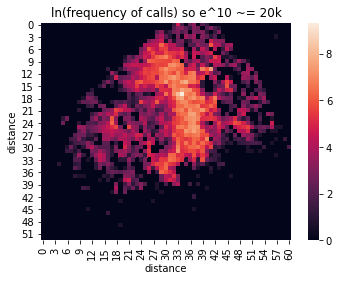

In [18]:
log_geo_freq = np.log(geo_freq + .01)
ax = sns.heatmap(log_geo_freq, square = True, vmin = 0) #, cbar_kws={"ticks":np.arange(0,40000,8000)}) #, cbar_ax = [0,10])

# #x = np.arange(2,10,2)
# y_ticks_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
# # Set number of ticks for x-axis
# ax.set_yticks(np.arange(0,7,1))
# # Set ticks labels for x-axis
# ax.set_yticklabels(y_ticks_labels, rotation='horizontal', fontsize=12)
plt.xlabel ('distance')
plt.ylabel ('distance')
plt.title('ln(frequency of calls) so e^10 ~= 20k')


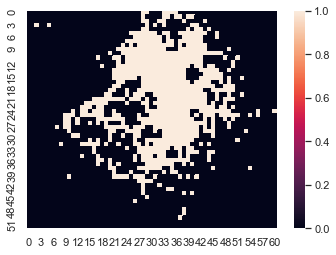

In [29]:
ax = sns.heatmap(bool_mask, square = True)

In [35]:
np.savetxt('geo_distribution.csv', geo_freq, delimiter=',') 
a = (np.genfromtxt("geo_distribution.csv", delimiter=","))

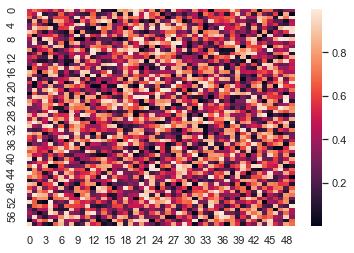

In [11]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
uniform_data = np.random.rand(60, 50)
ax = sns.heatmap(uniform_data)

In [12]:
len(a[0])

61